In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, confusion_matrix,matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import pickle
import numpy as np
from helperfunc import *
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

## Data Processing

First, we process the data. We load it, as presented in tha assignment statement

In [15]:

X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)

temp = 0
for i in y_train:
    temp+=i
temp = temp/len(y_train)
#print(temp)

print(np.mean(y_train))
print(np.var(y_train))
#these values are important to understand how 'strong' the error is


0.3883879501507428
0.0765282946318391


We pass the training set to a pandas dataframe just to use some of the usual functions.
Below, we check for null values on all sets. None exits. We can then proceed towards feature selection

In [12]:
import pandas as pd
df = pd.DataFrame(X_train, columns=col_names)
print(df.isnull().values.any())
df.describe()
#aight, no null values

False


,D00,D01,D02,D03,D04,D05,D06,D07,D08,D09,...,FP2079,FP2080,FP2081,FP2082,FP2083,FP2084,FP2085,FP2086,FP2087,FP2088
count,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,...,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000,7337.000000
mean,430.518010,431.037078,5.430285,1.206897,6.527327,1.128799,4.678070,30.497615,59.165190,6.594930,...,0.396211,0.036800,0.031075,0.088456,0.027668,0.011040,0.018264,0.038026,0.094725,0.036800
std,181.613020,181.757699,4.160569,2.527815,5.983082,2.218665,2.789156,12.882724,25.749585,4.403703,...,0.489143,0.188283,0.173533,0.283976,0.164031,0.104497,0.133912,0.191273,0.292855,0.188283
min,135.068414,135.166000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,19.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,357.124405,357.429000,4.000000,0.000000,4.000000,0.000000,3.000000,25.000000,49.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,419.107040,419.500000,5.000000,1.000000,6.000000,1.000000,4.000000,30.000000,57.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,472.228141,472.888000,6.000000,1.000000,8.000000,1.000000,6.000000,33.000000,65.000000,8.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3768.848446,3771.262000,92.000000,47.000000,137.000000,42.000000,58.000000,266.000000,527.000000,93.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


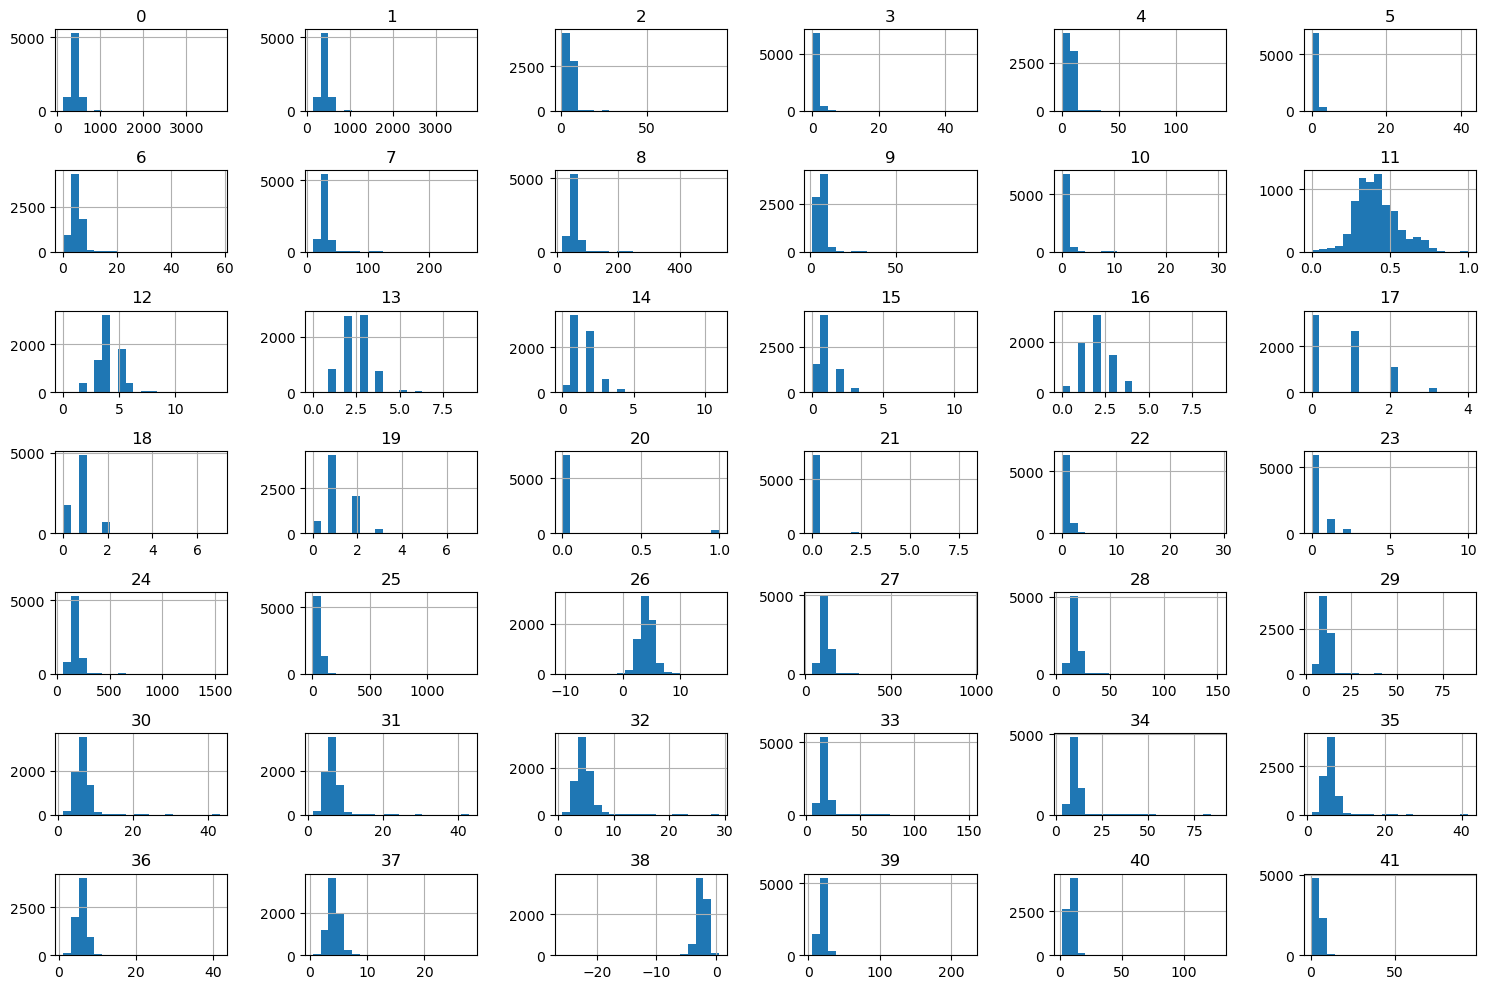

In [13]:
X_train = X_train[:,:42]
train_df = pd.DataFrame(X_train)
train_df.hist(bins=20, figsize=(15, 10))
plt.tight_layout() 
plt.show()

In [ ]:
df = pd.DataFrame(X_train, columns=col_names)

categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)

In [18]:
#Running this gives me a fresh dataset
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
df = pd.DataFrame(X_train, columns=col_names)
categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)

X_train=df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)

# Starting analysis

Looking at the whole dataset, we can see we have 44 columns of typical data, and 2000 and something of some sort of binary data. Lets run three different tests:
- one with the dataset as is
- one with a scaled dataset
- one with only the first part of the data (scaled)
- one with only the second part (also scaled)

In [29]:
def naif_model_testingR(X_train, X_test, y_train, y_test):
    #test 3 approaches and print out the results
    rfr= RandomForestRegressor(n_estimators=100, n_jobs= -1)
    rfr.fit(X_train, y_train)
    #this one is kinda slow, as usual

    dtr= DecisionTreeRegressor(max_depth=5)
    dtr.fit(X_train, y_train)

    lmr=LinearRegression()
    lmr.fit(X_train, y_train)

    rf_preds=rfr.predict(X_test)
    dt_preds=dtr.predict(X_test)
    lr_preds=lmr.predict(X_test)

    #should we do cross validation for this?
    print("RVE RFs: %7.4f" % explained_variance_score(y_test, rf_preds))
    print("MSE RFs: %7.4f" % mean_squared_error(y_test, rf_preds))
    print("RVE DTs: %7.4f" % explained_variance_score(y_test, dt_preds))
    print("MSE DTs: %7.4f" % mean_squared_error(y_test, dt_preds))
    print("RVE LRs: %7.4f" % explained_variance_score(y_test, lr_preds))
    print("MSE LRs: %7.4f" % mean_squared_error(y_test, lr_preds))

#this function was adapted from the TP
#it calculates the MSE of a couple of predictions with different models

In [21]:
naif_model_testingR(X_train, X_test, y_train, y_test)
#decent results straight up

RVE RFs:  0.6086
RVE DTs:  0.2563
RVE LRs: -4143883584773.7964


In [22]:
scaler   = MinMaxScaler()
scaler.fit(X_train)
Xt_train = scaler.transform(X_train)
Xt_test  = scaler.transform(X_test)

naif_model_testingR(X_train, X_test, y_train, y_test)

#horrendous results
#Because of the 'second' part of the data, which is binary, scaling isn't even smart

RVE RFs:  0.6145
RVE DTs:  0.2601
RVE LRs: -4143883584773.7964


Now, I have noted before this dataset is split between the first 40 something columns with 'normal' data, and a second part with binary data. Lets test this function with using both sets _independently_, and see how good it is.

coluna 1 - 43 são 'normais', dai para a frente são binary.
meaning, we split 0-42, and 42 - 

In [8]:
'''
Here, we pick the first part of the data.
Results aren't expected to be good. After this, we will scale this, and go again
'''
print('First part of the data, no scaling ')
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
X_train = X_train[:,:42]
X_test = X_test[:,:42]
naif_model_testingR(X_train, X_test, y_train, y_test)

print('First part of the data, scaled ')
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)

X_train = X_train[:,:42]
X_test = X_test[:,:42]
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
naif_model_testingR(X_train, X_test, y_train, y_test)


First part of the data, no scaling 
RVE RFs:  0.4474
RVE DTs:  0.1551
RVE LRs:  0.1371
First part of the data, scaled 
RVE RFs:  0.4069
RVE DTs:  0.0963
RVE LRs:  0.1368


In [10]:
'''
Now, we do the same for the second part of the data. Expected results to be horrendous, because this part of the 
data isn't supposed to be scaled, since its binary. Surprisingly, we get better results.
Readability is bad, but we are running the same exact thing every time, dont care.
'''
print('Second part of the data, no scaling ')
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
X_train = X_train[:,43:]
X_test = X_test[:,43:]
naif_model_testingR(X_train, X_test, y_train, y_test)
print('Second part of the data, scaled ')
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
X_train = X_train[:,43:]
X_test = X_test[:,43:]
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
naif_model_testingR(X_train, X_test, y_train, y_test)

Second part of the data, no scaling 
RVE RFs:  0.6179
RVE DTs:  0.2909
RVE LRs:  0.3752
Second part of the data, scaled 
RVE RFs:  0.6374
RVE DTs:  0.2895
RVE LRs:  0.3398


I was expecting that scaling this second part of the data would seriously destroy my predictions. However it didn't, for some reason, even though scaling binary data is crazy.

Regardless, since scaling everything seems good, we keep going.

In [130]:
#Running this gives me a fresh dataset
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
df = pd.DataFrame(X_train, columns=col_names)
categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)

X_train=df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
naif_model_testingR(X_train, X_test, y_train, y_test)

#Scaling gives us a small improvement overall.
#this is much more impactfull than it seems, since models like scaled data.

RVE RFs:  0.6162
MSE RFs:  0.0301
RVE DTs:  0.2749
MSE DTs:  0.0569
RVE LRs: -176600239528540640.0000
MSE LRs: 13852810255558484.0000


# FEATURE SELECTION

In [13]:
# Now we jump into feature selection
from sklearn.feature_selection import SelectFromModel
rfr=RandomForestRegressor(n_jobs=-1)
sel = SelectFromModel(estimator=rfr, threshold=.00005)
sel.fit(X_train, y_train)

print("Importances: ", sel.estimator_.feature_importances_)

print("Default threshold: ", sel.threshold_)

X_train=sel.transform(X_train)
X_test=sel.transform(X_test)
print(X_train.shape)
naif_model_testingR(X_train, X_test, y_train, y_test)

#I ran this with a bunch of different value for the treshhold
#this is the best, but its not an improvement

Importances:  [0.00354565 0.00381059 0.00223058 ... 0.00173542 0.00111449 0.00040886]
Default threshold:  5e-05
(4915, 1654)
RVE RFs:  0.6220
RVE DTs:  0.2865
RVE LRs:  0.4299


In [51]:
for i in range(0,2000, 100):
    X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
    df = pd.DataFrame(X_train, columns=col_names)
    categorical_columns = []
    for j in range(12,24):
        categorical_columns.append(col_names[j])
    df = pd.get_dummies(df, columns=categorical_columns)

    X_train=df.values.tolist()
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
    scaler   = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)

    print("PCA with components = ")
    print(i)
    pca = PCA(n_components=i)
    pca.fit(X_train)
    naif_model_testingR(X_train, X_test, y_train, y_test)

PCA with components = 
0
RVE RFs:  0.6030
MSE RFs:  0.0309
RVE DTs:  0.2560
MSE DTs:  0.0578
RVE LRs:  0.3383
MSE LRs:  0.0514
PCA with components = 
100
RVE RFs:  0.6288
MSE RFs:  0.0289
RVE DTs:  0.2891
MSE DTs:  0.0554
RVE LRs: -100172467375514009600.0000
MSE LRs: 7807656110263908352.0000
PCA with components = 
200
RVE RFs:  0.5961
MSE RFs:  0.0312
RVE DTs:  0.2627
MSE DTs:  0.0569
RVE LRs: -890940072325529075712.0000
MSE LRs: 69055070707207069696.0000
PCA with components = 
300
RVE RFs:  0.6093
MSE RFs:  0.0299
RVE DTs:  0.2162
MSE DTs:  0.0601
RVE LRs: -186026933852166619136.0000
MSE LRs: 14249738622645301248.0000
PCA with components = 
400
RVE RFs:  0.5943
MSE RFs:  0.0309
RVE DTs:  0.2354
MSE DTs:  0.0582
RVE LRs: -84527217918646272000.0000
MSE LRs: 6440700707137725440.0000
PCA with components = 
500
RVE RFs:  0.6149
MSE RFs:  0.0287
RVE DTs:  0.2630
MSE DTs:  0.0550
RVE LRs: -3520011996168683008.0000
MSE LRs: 263037484076660160.0000
PCA with components = 
600
RVE RFs:  0.6180
M

# Model Selection and Tuning

In [55]:
pca = PCA(n_components=1200)
pca.fit(X_train)
nX_train=pca.transform(X_train)
nX_test=pca.transform(X_test)
model = XGBRegressor(n_estimators=1200, max_depth=10, eta=0.001)
model.fit(nX_train, y_train)
preds = model.predict(nX_test)
print(explained_variance_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.41927869377978466
0.0462212127206204


In [31]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(explained_variance_score(y_test, preds))
print(mean_squared_error(y_test, preds))


0.6241248585555638
0.029090547452165834


### SVR

In [74]:
from sklearn.model_selection import GridSearchCV


gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

#define the model and do the grid search
svr = SVR()
gs = GridSearchCV(estimator=svr, param_grid=param_grid, scoring="explained_variance", n_jobs=-1)
gs=gs.fit(nX_train, y_train)

sorted(gs.cv_results_)
print(sorted(gs.cv_results_))

res = pd.DataFrame(gs.cv_results_)
res = res.sort_values(by=["rank_test_score"])
res[["params", "rank_test_score", "mean_score_time", "std_test_score"]]


['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_gamma', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


,params,rank_test_score,mean_score_time,std_test_score
6,"{'C': 1, 'gamma': 1e-07}",1,4.073460,0.000018
13,"{'C': 10, 'gamma': 1e-07}",2,3.980155,0.000176
5,"{'C': 1, 'gamma': 1e-06}",3,3.971704,0.000175
4,"{'C': 1, 'gamma': 1e-05}",4,4.069500,0.001516
20,"{'C': 100, 'gamma': 1e-07}",5,4.115199,0.001517
12,"{'C': 10, 'gamma': 1e-06}",6,4.005556,0.001517
27,"{'C': 1000.0, 'gamma': 1e-07}",7,4.650656,0.007128
3,"{'C': 1, 'gamma': 0.0001}",8,4.082413,0.007109
11,"{'C': 10, 'gamma': 1e-05}",9,4.001352,0.007163
19,"{'C': 100, 'gamma': 1e-06}",10,4.120951,0.007157


In [176]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
df = pd.DataFrame(X_train, columns=col_names)
categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)

X_train=df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

pca = PCA(n_components=900)
pca.fit(X_train)
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)

model =SVR(gamma=0.01, C=1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(explained_variance_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.6574182140893694
0.02597679585743473


### MLPs

In [120]:
#now, at last, for MLPs, we dont need any feature selection, since MLPs will just assign weight=0 to bad features
#Running this gives me a fresh dataset
from sklearn.neural_network import MLPRegressor


X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
df = pd.DataFrame(X_train, columns=col_names)
categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)

X_train=df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=0)
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
'''
arc=[(100,100), (150,150,150), (1000, 1000), (100,100), (10,10,10,10)]
act=['relu', 'identity', 'logistic', 'tanh']
sol=['lbfgs', 'sgd', 'adam']
for i in arc:
    for j in act:
        for k in sol:
'''

model =MLPRegressor(hidden_layer_sizes=(100,100,100,100,100, 100, 100), activation='tanh', solver='lbfgs', max_iter=20000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(explained_variance_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.535920783351439
0.0361179802115923


### Ensemble Learning

#### ADABoost, XGBoost and Gradient Boosting

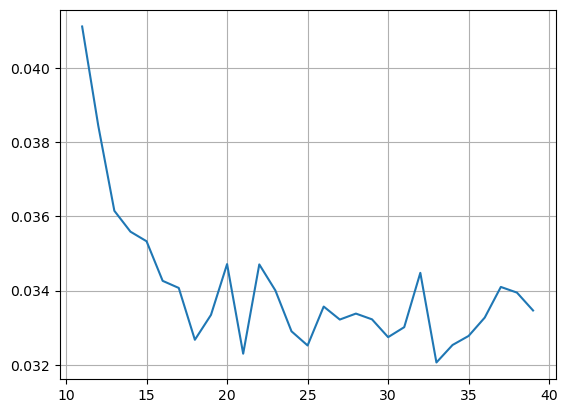

In [123]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
df = pd.DataFrame(X_train, columns=col_names)
categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)

X_train=df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

pca = PCA(n_components=1200)
pca.fit(X_train)
nX_train=pca.transform(X_train)
nX_test=pca.transform(X_test)



from sklearn.ensemble import AdaBoostRegressor
f1s=[]
for i in range(11,40):
    dt=DecisionTreeRegressor(max_depth=i) # its bugs out if I do this inside the adaboostclassifier
    abc = AdaBoostRegressor(estimator=dt, n_estimators=10)
    abc.fit(X_train, y_train)
    preds=abc.predict(X_test)
    f1s.append(mean_squared_error(y_test, preds))

plt.plot(range(11,40), f1s)
plt.grid()
plt.show()

In [158]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
'''
df = pd.DataFrame(X_train, columns=col_names)
categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)
X_train=df.values.tolist()
'''
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

from sklearn.ensemble import AdaBoostRegressor
dt=DecisionTreeRegressor(min_samples_leaf=3, max_depth=22) # its bugs out if I do this inside the adaboostclassifier
abc = AdaBoostRegressor(estimator=dt, n_estimators=300, learning_rate=0.001)
abc.fit(X_train, y_train)
preds=abc.predict(X_test)
score=(mean_squared_error(y_test, preds))

print(score)

0.030636067087418624


In [148]:
from sklearn.ensemble import GradientBoostingRegressor

abc = GradientBoostingRegressor(n_estimators= 500, learning_rate=0.001)
abc.fit(X_train, y_train)
preds=abc.predict(X_test)
score = (mean_squared_error(y_test, preds))

print(score)

0.06578677462584893


In [153]:
from sklearn.ensemble import GradientBoostingRegressor

base_estimator = RandomForestRegressor(n_jobs=-1)
model = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=200, learning_rate=0.01)
abc.fit(X_train, y_train)
preds=abc.predict(X_test)
score = (mean_squared_error(y_test, preds))
print(score)

0.06578677462584893


In [ ]:
X_train, X_ivs, y_train, col_names = pickle.load(open("drd2_data.pickle", "rb"))
df = pd.DataFrame(X_train, columns=col_names)
categorical_columns = []
for i in range(12,24):
    categorical_columns.append(col_names[i])
df = pd.get_dummies(df, columns=categorical_columns)

X_train=df.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33)
scaler   = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

pca = PCA(n_components=1200)
pca.fit(X_train)
nX_train=pca.transform(X_train)
nX_test=pca.transform(X_test)

for i in range(1,10):
    for j in range(1, 30):
        abc = RandomForestRegressor(min_samples_leaf=i, max_depth=j, n_jobs=-1)
        abc.fit(X_train, y_train)
        preds=abc.predict(X_test)
        RFR_score = (mean_squared_error(y_test, preds))
        print(i,j)
        print(RFR_score)